In [1]:
import bw2data as bd
from datetime import datetime
bd.projects.set_current("timex")
bd.databases

/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


Databases dictionary with 8 object(s):
	Mobility example
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei310_IMAGE_SSP2_RCP19_2020_electricity
	ei310_IMAGE_SSP2_RCP19_2030_electricity
	ei310_IMAGE_SSP2_RCP19_2040_electricity
	foreground
	test_small

In [2]:
db_bio = bd.Database("ecoinvent-3.10-biosphere") 

# Create a dict of databases keyed by year
dbs = {
    2020: bd.Database("ei310_IMAGE_SSP2_RCP19_2020_electricity"),
    # 2030: bd.Database("ei310-SSP2-RCP19-2030"),
    2030: bd.Database("ei310_IMAGE_SSP2_RCP19_2030_electricity"),
    2040: bd.Database("ei310_IMAGE_SSP2_RCP19_2040_electricity"),
}

# Add representative_time metadata for each database
for year, db in dbs.items():
    db.metadata["representative_time"] = datetime(year, 1, 1).isoformat()

eidb = bd.Database("ecoinvent-3.10-cutoff")
db_2020 =dbs[2020]

if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.write({})
foreground.register()

In [3]:
original_bg_activities_el = {
    "wind_onshore": db_2020.get(name="electricity production, wind, 1-3MW turbine, onshore", location="DE"),
    "wind_offshore": db_2020.get(name="electricity production, wind, 1-3MW turbine, offshore", location="DE"),
    "hydro_reservoir": db_2020.get(name="electricity production, hydro, reservoir, non-alpine region", location="DE"),
    "hydro_run_of_river": db_2020.get(name="electricity production, hydro, run-of-river", location="DE"),
    "lignite": db_2020.get(name="electricity production, lignite", location="DE"),
    "photovoltaic": db_2020.get(name="electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted", location="DE"),
    "wood_chips_cogen": db_2020.get(name="heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014", location="DE", unit="kilowatt hour"),
    "bio_gas_cogen": db_2020.get(name="heat and power co-generation, biogas, gas engine", location="DE", unit="kilowatt hour"),
    "fuel_cell_cogen": db_2020.get(name="electricity, residential, by conversion of hydrogen using fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid", unit="kilowatt hour"), 
}

original_bg_activities_heat = {
    "natural_gas_boiler": db_2020.get(name="heat production, natural gas, at boiler modulating >100kW", location="Europe without Switzerland", unit="megajoule"),
    "wood_chips_cogen": db_2020.get(name="heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014", location="DE", unit="megajoule"),
    "bio_gas_cogen": db_2020.get(name="heat and power co-generation, biogas, gas engine", location="DE", unit="megajoule"),
    "fuel_cell_cogen": db_2020.get(name="heat, residential, by conversion of hydrogen using fuel cell, PEM, allocated by exergy, distributed by pipeline, produced by Electrolysis, PEM using electricity from grid", unit="megajoule"), 
}

for key, act in original_bg_activities_el.items():
    fg_act = act.copy(code=f"elec_prod_{key}", database=foreground.name)
    fg_act["name"] = f"electricity production, {key}, time-explicit"
    fg_act["functional flow"] = "electricity"
    fg_act.save()

for key, act in original_bg_activities_heat.items():
    fg_act = act.copy(f"heat_prod_{key}", database=foreground.name)
    fg_act["name"] = f"heat production, {key}, time-explicit"
    fg_act["functional flow"] = "heat"
    fg_act.save()

In [4]:
temporal_dict = {
    "wind_onshore": (22, 2),
    "wind_offshore": (22, 2),
    "hydro_reservoir": (50, 3),
    "hydro_run_of_river": (50, 3),
    "lignite": (45, 3),
    "photovoltaic": (27, 1),
    "natural_gas_boiler": (20, 1),
    "wood_chips_cogen": (25, 2),
    "bio_gas_cogen": (25, 2),
    "fuel_cell_cogen": (10, 1),
    "municipal_waste": (30, 2),
}

In [5]:
#TODO: check for potential improvements for mapping quality based on metadata
import numpy as np
import bw_temporalis as bwt

def set_temporal_distribution(activity: bd.backends.proxies.Activity, construction_time, lifetime):  
    td_construction = bwt.easy_timedelta_distribution(
        start=0,
        end=construction_time,
        resolution="Y",
        steps=(construction_time + 1),
        kind="uniform" if construction_time < 2 else "triangular",
    )

    td_use_phase = bwt.easy_timedelta_distribution(
        start=construction_time,
        end=construction_time+lifetime,
        resolution="Y",
        steps=(lifetime + 1),
        kind="uniform",
    )

    td_decommissioning = bwt.TemporalDistribution(
        date=np.array([construction_time + lifetime + 1], dtype="timedelta64[Y]"), amount=np.array([1])
    )

    # construction_keywords = ["construct", "build", "install", "erect", "assemble", "fabricate", "manufacture"]
    # operation_keywords = ["use", "operation", "maintenance", "yearly" , "annual", "supply"]
    # end_of_life_keywords = ["end of life", "decommission", "disposal", "recycling"]
    for exc in activity.exchanges():
        phase = None

        # Determine the lifecycle phase based on the exchange name
        # exc_name = exc.input["name"].lower()
        # exc_comment = exc.input.get("comment", "").lower()
        # if any(keyword in exc_name or exc_comment for keyword in construction_keywords):
        #     phase = "construction"
        # elif any(keyword in exc_name or exc_comment for keyword in end_of_life_keywords):
        #     phase = "decommissioning"
        # elif any(keyword in exc_name or exc_comment for keyword in operation_keywords):
        #     phase = "use"

        if phase == None or exc["type"] == "production": # default to operation
            phase = "use"

        hardcoded_construction_exchanges = [
            "market for dust collector, electrostatic precipitator, for industrial use",
            "market for furnace, wood chips, with silo, 5000kW",
            "market for heat and power co-generation unit, organic Rankine cycle, 1000kW electrical",
            "fuel cell system assembly, 1 kWe, proton exchange membrane (PEM)",
            "market for photovoltaic slanted-roof installation, 3kWp, multi-Si, panel, mounted, on roof",
            "lignite power plant construction",
            "market for wind power plant, 2MW, offshore, fixed parts",
            "market for wind power plant, 2MW, offshore, moving parts",
            "market for wind turbine, 2MW, onshore",
            "market for wind turbine network connection, 2MW, onshore",
            "market for transport, freight, lorry 7.5-16 metric ton, EURO3",
            "gas power plant construction, combined cycle, 400MW electrical",
            "market for hydropower plant, run-of-river",
            "market for hydropower plant, reservoir, non-alpine regions",
            "heat and power co-generation unit construction, 160kW electrical, common components for heat+electricity",
            "heat and power co-generation unit construction, 160kW electrical, components for electricity only",
            "heat and power co-generation unit construction, 160kW electrical, components for heat only",  
            "industrial furnace production, natural gas", 
        ]

        if exc["name"] in hardcoded_construction_exchanges:
            phase = "construction"
            
        if phase == "construction":
            exc["temporal_distribution"] = td_construction
        elif phase == "use":
            exc["temporal_distribution"] = td_use_phase
        elif phase == "decommissioning":
            exc["temporal_distribution"] = td_decommissioning
        exc.save()
    return activity

for act in foreground:
    key = next((k for k in temporal_dict if k in act['name'].lower()), None)
    if key:
        lifetime, construction_time = temporal_dict[key]
        set_temporal_distribution(act, construction_time, lifetime)
    act.save()

In [6]:
import numpy as np

demand_el = np.asarray([
    0, 0, 0, 0, 0, 56157, 56437, 55606, 57717, 57773, 55931, 60914, 71943, 84358, 
    98228, 107249, 112607, 111032, 106403, 104333, 102018, 105039, 111936, 111687, 
    110604, 113000, 114266, 119847, 111721, 115637
]) * 1e3

demand_heat = np.asarray([
    0, 0, 0, 0, 0, 262809, 269709, 273258, 298326, 344994, 382277, 428253, 434335, 
    442742, 436880, 444756, 434184, 409388, 408375, 414480, 445917, 443459, 439623, 
    419441, 429527, 423834, 414716, 414119, 407104, 407320
]) * 1e3

years = np.arange(2020, 2050)

td_demand_el = bwt.TemporalDistribution(
    date=np.arange(2020-1970, 30, dtype="datetime64[Y]"), 
    amount=demand_el
)
td_demand_heat = bwt.TemporalDistribution(
    date=np.arange(2020-1970, 30, dtype="datetime64[Y]"), 
    amount=demand_heat
)

demand_input = {
    "electricity": td_demand_el,
    "heat": td_demand_heat,
}

In [ ]:
for act in foreground:
    if "electricity" in act["reference product"]:
        act["reference product"] = "electricity"
    elif "heat" in act["reference product"]:
        act["reference product"] = "heat"
    act.save()
    

Setting electricity production, hydro_reservoir, time-explicit to electricity
Setting electricity production, hydro_run_of_river, time-explicit to electricity
Setting electricity production, wind_offshore, time-explicit to electricity
Setting electricity production, wind_onshore, time-explicit to electricity
Setting electricity production, wood_chips_cogen, time-explicit to electricity
Setting electricity production, lignite, time-explicit to electricity
Setting heat production, natural_gas_boiler, time-explicit to heat
Setting heat production, wood_chips_cogen, time-explicit to heat
Setting electricity production, photovoltaic, time-explicit to electricity
Setting heat production, bio_gas_cogen, time-explicit to heat
Setting electricity production, bio_gas_cogen, time-explicit to electricity
Setting heat production, fuel_cell_cogen, time-explicit to heat
Setting electricity production, fuel_cell_cogen, time-explicit to electricity


In [13]:
from datetime import datetime
method = ('EF v3.1 no LT',
  'climate change no LT',
  'global warming potential (GWP100) no LT')

In [14]:
demand_input

{'electricity': TemporalDistribution instance with 30 values and total: 2.312e+09,
 'heat': TemporalDistribution instance with 30 values and total: 9.93e+09}

In [15]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand=demand_input,
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
        "database_dates": {
            "ei310_IMAGE_SSP2_RCP19_2020_electricity": datetime(2020, 1, 1),
        },
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": method,
            "metric": "CRF", # CRF
        },
        {
            "category_name": "resource_depletion",
            "brightway_method": (
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
        },
    ],
)

In [16]:
lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2025-06-16 07:18:01.441 | INFO     | optimex.lca_processor:_parse_demand:325 - Identified demand in system time range of %s for functional flows %s
2025-06-16 07:18:01.628 | INFO     | optimex.lca_processor:_construct_foreground_tensors:450 - Constructed foreground tensors.
2025-06-16 07:18:01.628 | INFO     | optimex.lca_processor:log_tensor_dimensions:445 - Technosphere shape: (13 processes, 39 flows, 54 years) with 1729 total entries.
2025-06-16 07:18:01.629 | INFO     | optimex.lca_processor:log_tensor_dimensions:445 - Biosphere shape: (13 processes, 127 flows, 53 years) with 6751 total entries.
2025-06-16 07:18:01.629 | INFO     | optimex.lca_processor:log_tensor_dimensions:445 - Production shape: (13 processes, 2 flows, 53 years) with 369 total entries.
2025-06-16 07:18:01.630 | INFO     | optimex.lca_processor:_calculate_inventory_of_db:488 - Calculating inventory for database: ei310_IMAGE_SSP2_RCP19_2020_electricity
/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-

TypeError: must be a CSC/CSR matrix (is <class 'scipy.sparse._csc.csc_array'>)

In [30]:
from optimex import converter
manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor) 
# manager.save("model_inputs.json") # if you want to save the model inputs to a file
# manager.load("model_inputs.json") # if you want to load the model inputs from a file
optimization_model_inputs.model_dump()


{'PROCESS': [],
 'REFERENCE_PRODUCT': ['heat', 'electricity'],
 'INTERMEDIATE_FLOW': [],
 'ELEMENTARY_FLOW': [],
 'BACKGROUND_ID': ['ei310_IMAGE_SSP2_RCP19_2020_electricity'],
 'PROCESS_TIME': [],
 'SYSTEM_TIME': [2020,
  2021,
  2022,
  2023,
  2024,
  2025,
  2026,
  2027,
  2028,
  2029,
  2030,
  2031,
  2032,
  2033,
  2034,
  2035,
  2036,
  2037,
  2038,
  2039,
  2040,
  2041,
  2042,
  2043,
  2044,
  2045,
  2046,
  2047,
  2048,
  2049],
 'CATEGORY': ['resource_depletion', 'climate_change'],
 'demand': {('electricity', 2020): 0.0,
  ('electricity', 2021): 0.0,
  ('electricity', 2022): 0.0,
  ('electricity', 2023): 0.0,
  ('electricity', 2024): 0.0,
  ('electricity', 2025): 56157000.0,
  ('electricity', 2026): 56437000.0,
  ('electricity', 2027): 55606000.0,
  ('electricity', 2028): 57717000.0,
  ('electricity', 2029): 57773000.0,
  ('electricity', 2030): 55931000.0,
  ('electricity', 2031): 60914000.0,
  ('electricity', 2032): 71943000.0,
  ('electricity', 2033): 84358000.0,

In [36]:
optimization_model_inputs.PROCESS

[]

In [32]:
# additional constraint coupling capacity of heat and electricity co-generation
name_process_dict = {v: k for k, v in opt.processes.items()}
process_coupling = {
    (name_process_dict["heat production, wood_chips_cogen, time-explicit"],
        name_process_dict["electricity production, wood_chips_cogen, time-explicit"]): 10.8,
    (name_process_dict["heat production, fuel_cell_cogen, time-explicit"],
        name_process_dict["electricity production, fuel_cell_cogen, time-explicit"]): 3.6,
    (name_process_dict["heat production, bio_gas_cogen, time-explicit"],
        name_process_dict["electricity production, bio_gas_cogen, time-explicit"]): 6.18 ,
}
optimization_model_inputs.process_coupling = process_coupling

NameError: name 'opt' is not defined

In [11]:
# optimization_model_inputs.category_impact_limit = {
#     "resource_depletion": 1,
# }


In [12]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "climate_change",
    flexible_operation = False, # Feel free to change this to see both
)

2025-06-15 12:05:07.637 | INFO     | optimex.optimizer:create_model:67 - Creating sets
2025-06-15 12:05:07.638 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-15 12:05:07.696 | INFO     | optimex.optimizer:create_model:272 - Creating variables


In [13]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-15 12:05:11.078 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-15 12:05:14.721 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 1506.35
2025-06-15 12:05:14.722 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   1.72654e-07


In [14]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

some scaling issue is going on here, look at land use and what it was constrainted to

In [21]:
import pyomo.environ as pyo
{
            (t, p): pyo.value(model.var_installation[p, t])
            for p in model.PROCESS
            for t in model.SYSTEM_TIME
        }

{(2020, 'hydrogen_production_pem'): 0.0,
 (2021, 'hydrogen_production_pem'): 0.0,
 (2022, 'hydrogen_production_pem'): 0.0,
 (2023, 'hydrogen_production_pem'): 0.0,
 (2024, 'hydrogen_production_pem'): 0.0,
 (2025, 'hydrogen_production_pem'): 0.0,
 (2026, 'hydrogen_production_pem'): 0.0,
 (2027, 'hydrogen_production_pem'): 0.0,
 (2028, 'hydrogen_production_pem'): 0.0,
 (2029, 'hydrogen_production_pem'): 0.0,
 (2030, 'hydrogen_production_pem'): 0.0,
 (2031, 'hydrogen_production_pem'): 0.0,
 (2032, 'hydrogen_production_pem'): 0.0,
 (2033, 'hydrogen_production_pem'): 0.0,
 (2034, 'hydrogen_production_pem'): 0.0,
 (2035, 'hydrogen_production_pem'): 0.0,
 (2036, 'hydrogen_production_pem'): 0.0,
 (2037, 'hydrogen_production_pem'): 0.0,
 (2038, 'hydrogen_production_pem'): 0.0,
 (2039, 'hydrogen_production_pem'): 0.0,
 (2040, 'hydrogen_production_pem'): 0.0,
 (2041, 'hydrogen_production_pem'): 0.0,
 (2042, 'hydrogen_production_pem'): 0.0,
 (2043, 'hydrogen_production_pem'): 0.0,
 (2044, 'hydroge

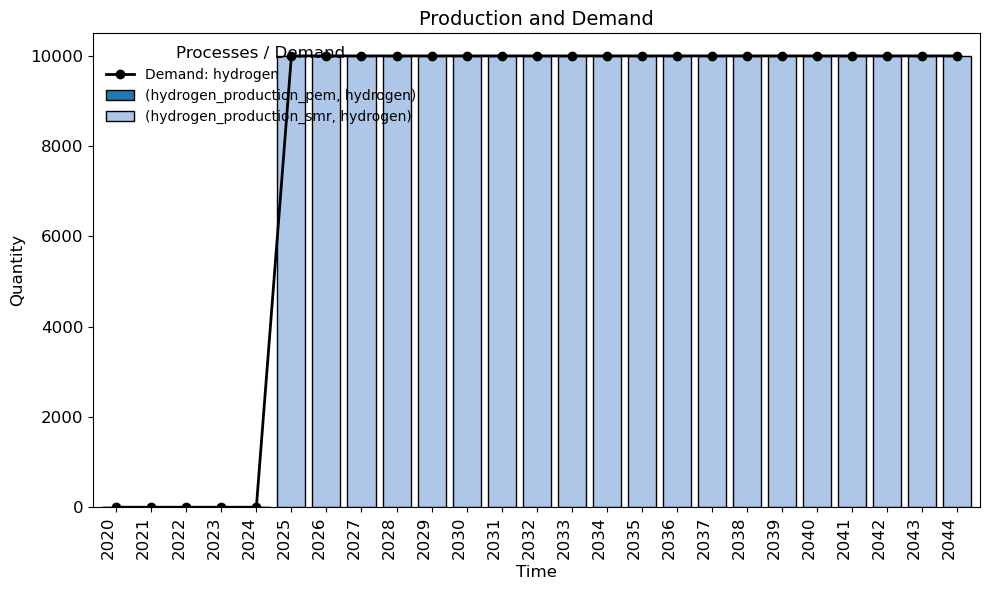

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Quantity'>)

In [15]:
pp.plot_production_and_demand()

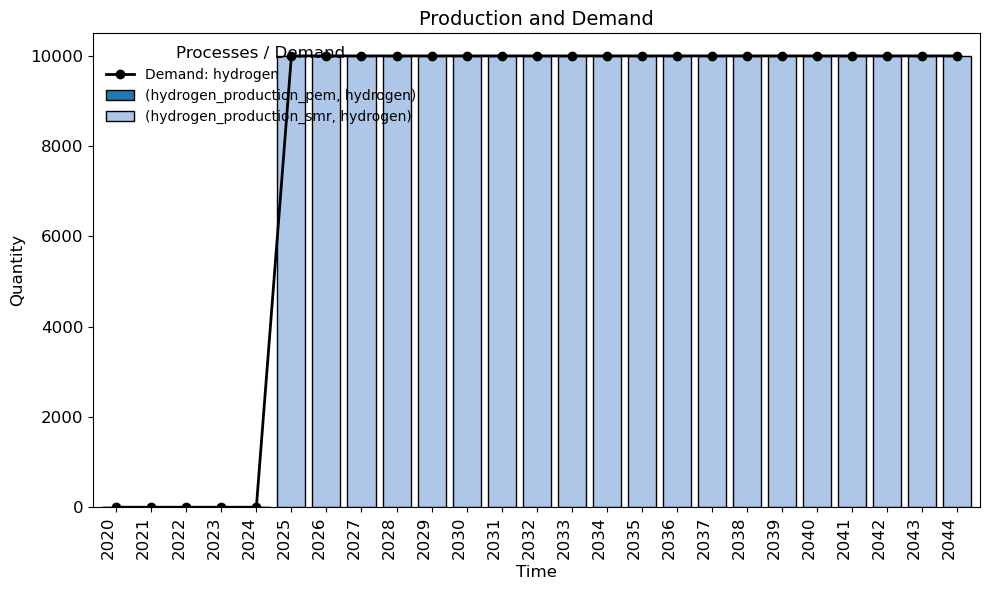

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Production and Demand'}, xlabel='Time', ylabel='Quantity'>)

In [19]:
pp.plot_production_and_demand()

In [17]:
pp.get_installation()

Process,hydrogen_production_pem,hydrogen_production_smr
Time,,
2020,0.0,0.0
2021,0.0,0.0
2022,0.0,110000.0
2023,0.0,0.0
2024,0.0,0.0
2025,0.0,0.0
2026,0.0,0.0
2027,0.0,0.0
2028,0.0,0.0


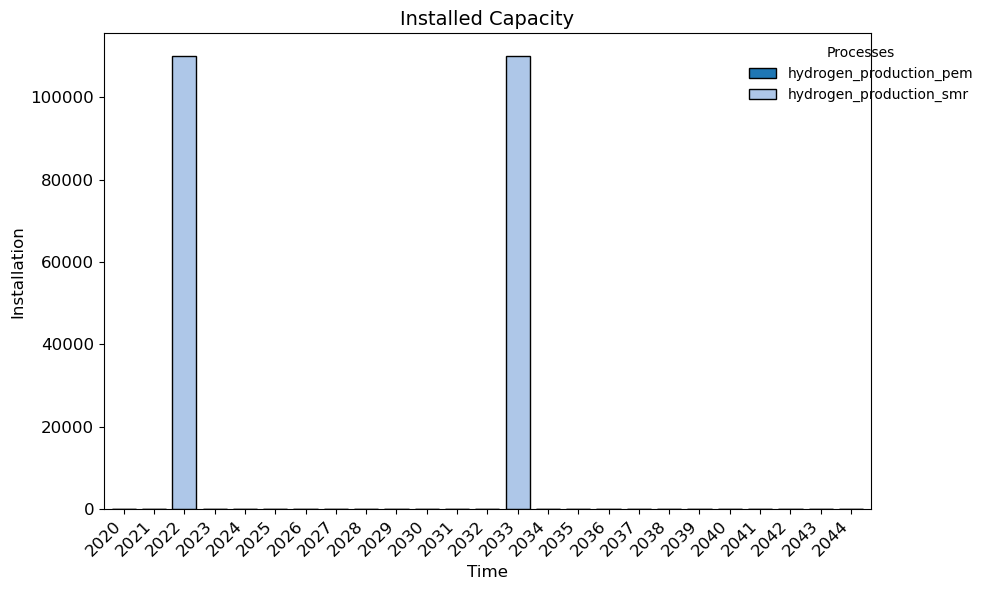

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Installed Capacity'}, xlabel='Time', ylabel='Installation'>)

In [18]:
pp.plot_installation()

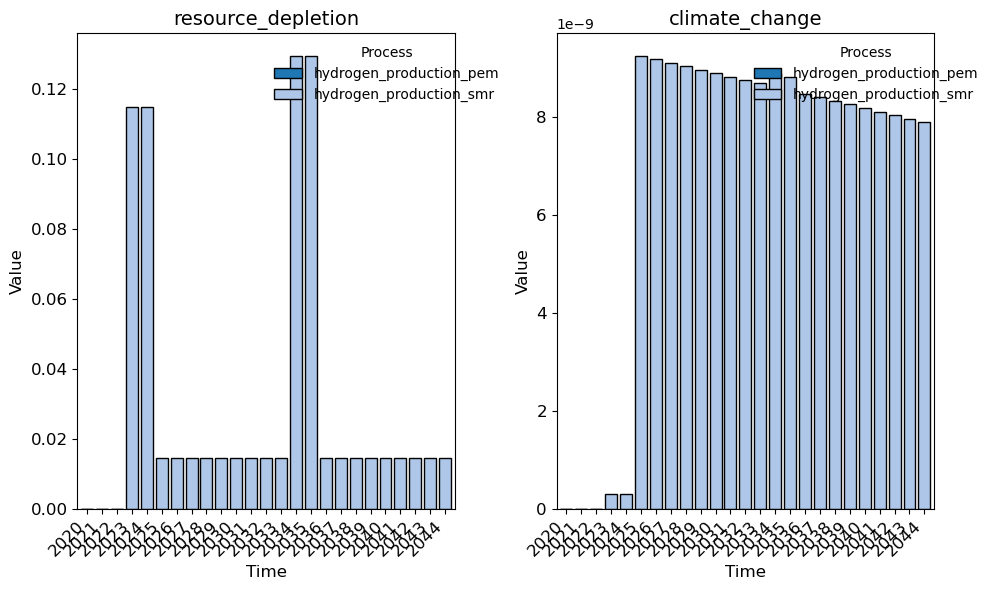

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'resource_depletion'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

In [19]:
pp.plot_impacts()

opt land use

In [55]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name = "demo_simple_example",
    objective_category = "resource_depletion",
    flexible_operation = True, # Feel free to change this to see both
)

2025-06-13 13:01:23.075 | INFO     | optimex.optimizer:create_model:67 - Creating sets


2025-06-13 13:01:23.078 | INFO     | optimex.optimizer:create_model:109 - Creating parameters
2025-06-13 13:01:23.149 | INFO     | optimex.optimizer:create_model:272 - Creating variables


In [56]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False) # choose solver here, e.g. "gurobi", "cplex", "glpk", etc.

2025-06-13 13:01:28.843 | INFO     | optimex.optimizer:solve_model:601 - Solver [glpk] termination: optimal
2025-06-13 13:01:31.970 | INFO     | optimex.optimizer:solve_model:626 - Objective (scaled): 0.051816
2025-06-13 13:01:31.970 | INFO     | optimex.optimizer:solve_model:627 - Objective (real):   0.5647


In [82]:
import bw2calc as bc

In [83]:
lca = bc.LCA(
    demand={db_2020.get(name="hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity", unit="kilogram"): 10000},
    method=(
                "EF v3.1 no LT",
                "material resources: metals/minerals no LT",
                "abiotic depletion potential (ADP): elements (ultimate reserves) no LT",
            ),
)

In [84]:
lca.lci()
lca.lcia()
print("Total impact:", lca.score)

Total impact: 2.534332848350403


/Users/timodiepers/anaconda3/envs/optimex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.13e+13)
  warnings.warn(msg, UmfpackWarning)


In [120]:
import pyomo.environ as pyo 
fg_scale = getattr(pp.m, "scales", {}).get("foreground", 1.0)
inventory = {
    (p, e, t): pyo.value(pp.m.scaled_inventory[p, e, t]) * fg_scale
    for p in pp.m.PROCESS
    for e in pp.m.ELEMENTARY_FLOW
    for t in pp.m.SYSTEM_TIME
}

import pandas as pd

dynamic_inventory_df = pd.DataFrame.from_records(
    [(p, e, t, v) for (p, e, t), v in inventory.items()],
    columns=["activity", "flow", "date", "amount"]
).astype({
    "activity": "str",
    "flow": "str",
    "date": "datetime64[s]",
    "amount": "float64"
})

In [121]:
dynamic_inventory_df["flow"] = dynamic_inventory_df["flow"].apply(
    lambda x: db_bio.get(code=x).id
)

In [122]:
from dynamic_characterization import characterize

df_characterized = characterize(
        dynamic_inventory_df,
        metric="radiative_forcing", # could also be GWP
        base_lcia_method=method,
        time_horizon=100,
)

2025-06-13 19:22:20.514 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


<Axes: >

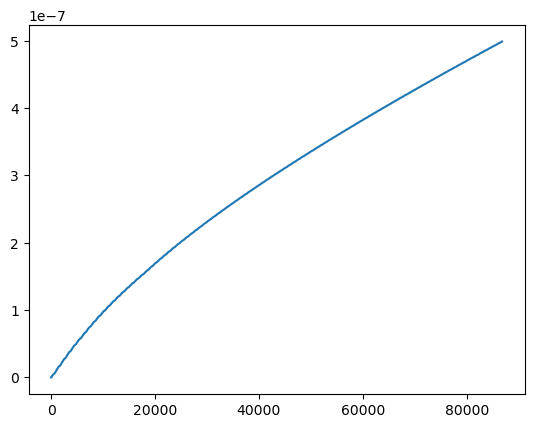

In [123]:
df_characterized.amount.cumsum().plot()

<Axes: >

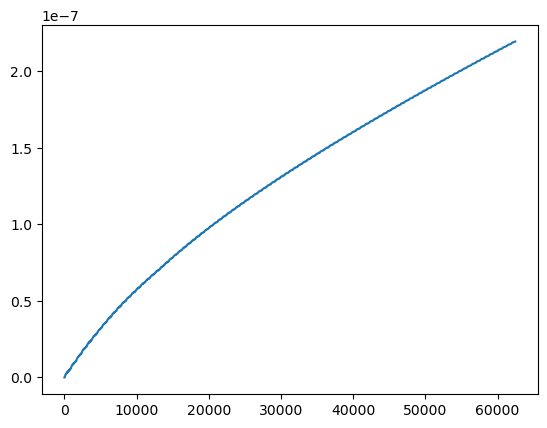

In [ ]:
df_characterized.amount.cumsum().plot()

In [75]:
import pandas as pd

inventory_df = pd.DataFrame.from_dict(inventory, orient='index', columns=['amount'])

In [ ]:
inventory_df

In [57]:
from optimex import postprocessing
pp = postprocessing.PostProcessor(m)

df_impact = pp.get_impacts()
df_impact

Category      resource_depletion                          \
Process  hydrogen_production_smr hydrogen_production_pem   
Time                                                       
2020                    0.000000                     0.0   
2021                    0.000000                     0.0   
2022                    0.171468                     0.0   
2023                    0.173528                     0.0   
2024                    0.000000                     0.0   
2025                    0.014503                     0.0   
2026                    0.014507                     0.0   
2027                    0.014510                     0.0   
2028                    0.014514                     0.0   
2029                    0.014517                     0.0   
2030                    0.014521                     0.0   
2031                    0.014564                     0.0   
2032                    0.014607                     0.0   
2033                    0.014650                     0.0   
2034                    0.014694                     0.0   
2035                    0.014737                     0.0   
2036                    0.014780                     0.0   
2037                    0.014823                     0.0   
2038                    0.014867                     0.0   
2039                    0.014910                     0.0   

Category          climate_change                          
Process  hydrogen_production_smr hydrogen_production_pem  
Time                                                      
2020                0.000000e+00                     0.0  
2021                0.000000e+00                     0.0  
2022                4.210835e-10                     0.0  
2023                4.006688e-10                     0.0  
2024                0.000000e+00                     0.0  
2025                9.207497e-09                     0.0  
2026                9.131335e-09                     0.0  
2027                9.055108e-09                     0.0  
2028                8.978811e-09                     0.0  
2029                8.902443e-09                     0.0  
2030                8.826000e-09                     0.0  
2031                8.753540e-09                     0.0  
2032                8.680933e-09                     0.0  
2033                8.608175e-09                     0.0  
2034                8.535262e-09                     0.0  
2035                8.462190e-09                     0.0  
2036                8.388956e-09                     0.0  
2037                8.315556e-09                     0.0  
2038                8.241985e-09                     0.0  
2039                8.168240e-09                     0.0

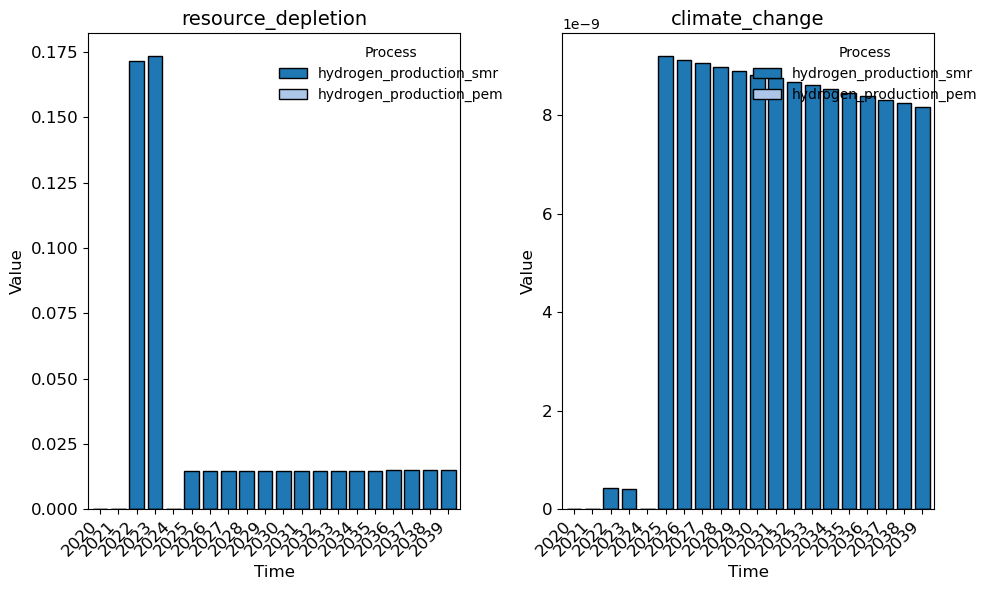

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'resource_depletion'}, xlabel='Time', ylabel='Value'>,
        <Axes: title={'center': 'climate_change'}, xlabel='Time', ylabel='Value'>],
       dtype=object))

In [58]:
pp.plot_impacts()